<div class="alert alert-block alert-warning"><b>PLEASE READ BEFORE:</b><br>
    1. This notebook is a quick walkthrough of the major discorveries I have found in the zillow clustering project.<br>
    2. Hence, it doesn't contain all the work I have done.<br> 
    3. The complete work could be found in the explore_zillow.ipynb, cluster_zillow.ipynb and model_zillow.ipynb.<br>
    4. Since this notebook is also used for presentation, the slides are styled with block quoting and in Italic text.</div>

In [12]:
# Set up the environment

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

import acquire, summarize, prepare, wrangle_zillow, features, model

from IPython.display import Image

> ## *Exploring the Drivers of the Logerror in the Zestimate*
> ### *Presented by: Yongliang Shi*
> ### *Date: Oct 21, 2020*

> ## *Goal: to uncover what the drivers of the error in the zestimate are*
  - ### *Step 1: Explore the Target Variable Logerror*
  - ### *Step 2: Clustering Logerror*
  - ### *Step 3: Modeling and Evalution*

In [13]:
# Acquire the zillow dataset
zillow = acquire.get_zillow_clustering()

# Wrangle the zillow dataset for exploration
train, validate, test = wrangle_zillow.wrangle_zillow_clustering(zillow)

# Map fips to county names
train.fips = train.apply(lambda i: wrangle_zillow.add_county_column(i), axis=1)

# Create a variable to hold the target variable
target_var = train.logerror

> ## *Explore Target Variable - What does the logerror look like?* 

In [14]:
# Print the descriptive statistics of the target variable logerror

percentiles = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
train.logerror.describe(percentiles).round(3)

count    31028.000
mean         0.020
std          0.178
min         -4.655
10%         -0.071
20%         -0.035
25%         -0.024
30%         -0.016
40%         -0.004
50%          0.007
60%          0.018
70%          0.031
75%          0.041
80%          0.053
90%          0.105
max          3.395
Name: logerror, dtype: float64

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The logerror ranges from -4.7 to 3.4.<br>
    2. The mean is 0.02 and the median is 0.007.<br>
    3. Majority of the data (about 80%) falls in the range from -0.1 to 0.1.</div>

> ## *Explore Target Varibale logerror - What does the number mean?* 
  - ### *logerror = $\log(zestimate) - log(saleprice)$  =  $\log(zestimate/saleprice)$*
      - ### *if logerror = -4.655(min) --> zestimate / sale price = 0.00002*
      - ### *if logerror = 0.007(50%) --> zestimate / sale price = 1.016*
      - ### *if logerror = 3.395(max) --> zestimate / sale price = 2483*

[Text(0.5, 0, '')]

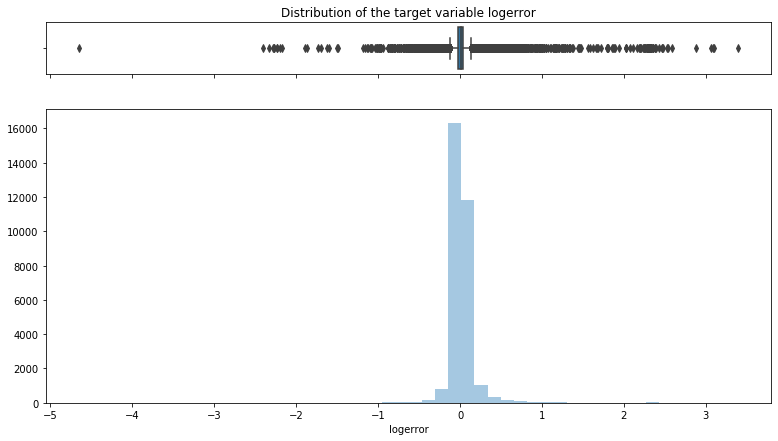

In [15]:
# Visualize the logerror distribution by boxplot at the top and histogram at the bottom.

# Cut the window into 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(13,7),  
                                      gridspec_kw={"height_ratios": (0.15, 0.85)})

# Add the graphs in each part
sns.boxplot(target_var, ax=ax_box)
sns.distplot(target_var, kde=False, ax=ax_hist)

# Add title
ax_box.set_title('Distribution of the target variable logerror')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Finally, the picture is saved as logerror_dist.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. Most of the log errors are around zero.<br>
    2. Plenty of outliers exsis, as shown in the boxplot.<br>
    3. The shape of the distribution looks normal.</div>

> ## *Explore Target Varibale logerror* 
  - ### *logerror = $\log(zestimate) - log(saleprice)$  =  $\log(zestimate/saleprice)$*
      - ### *Sale price is not available, but...*
      - ### *Assessed value: taxvaluedollarcnt, which has been modeled in the previous regression project.*

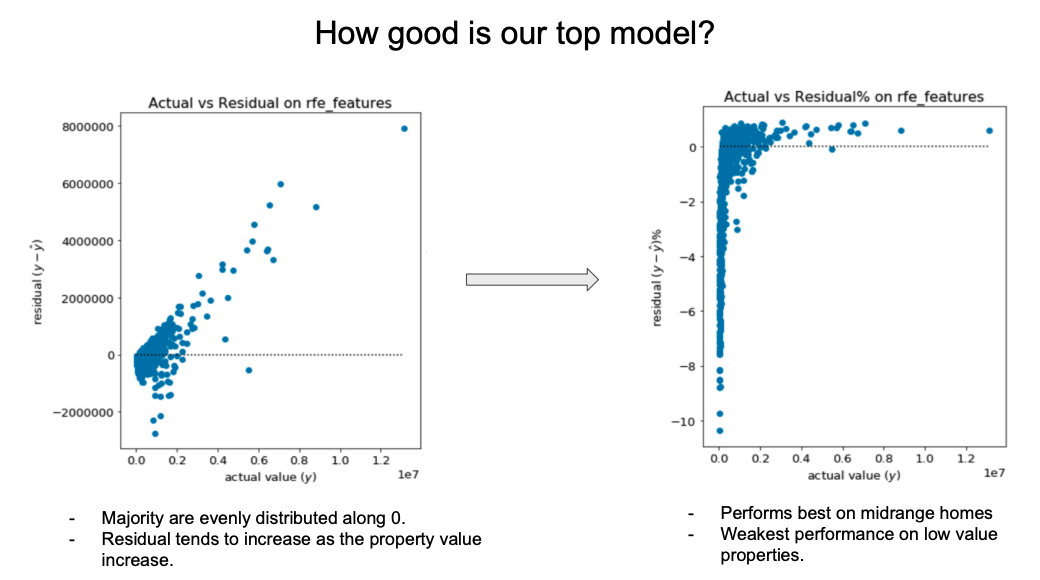

In [16]:
# Load residual analysis result from regression project

Image(filename = "regression_model_performance.png", width = 750, height = 500)

<div class="alert alert-block alert-info"><b>Takeaways:</b><br> 
    1. When I built the regression models, the most important takeaway from that is I found the model error, which is represented by residuals or residual percentage, is related to tax value dollar cnt.<br>
    2. It is worth noticing that the largest errors come from the properties with low values.</div>

> ## *Does the statement below stand true?*
> ### *- Our target variable logerror is related to the assessed value?* 

Text(0.5, 1.0, 'Distribtion of logerror against log(assessed values)')

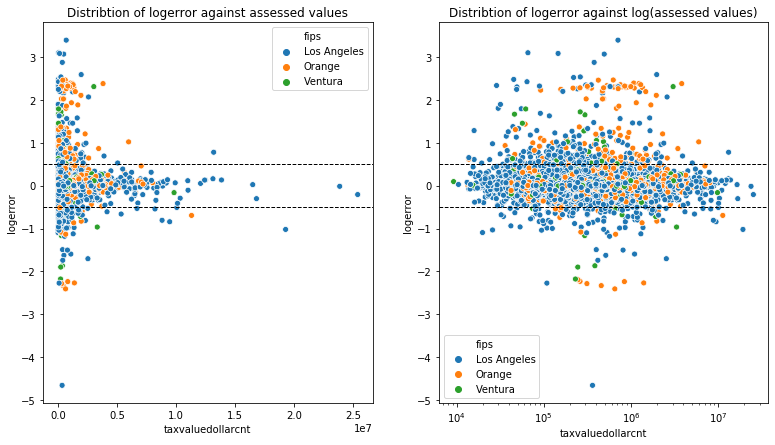

In [17]:
# Plot distribution of logerror against assessed value (taxvaluedollarcnt)
plt.figure(figsize=(13,7))

# against taxvaluedollarcnt
plt.subplot(121)
sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribtion of logerror against assessed values')

# against log(taxvaluedollarcnt)
plt.subplot(122)
ax = sns.scatterplot(data=train, x='taxvaluedollarcnt', y='logerror', hue='fips')
ax.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribtion of logerror against log(assessed values)')

# Finally, the picture is saved as logerror_taxvalue.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways: similar pattern is observed</b><br> 
    1. On the left: The log error tends to increase in both ways, whether positive or negative as the property value drops.<br>
    2. On the right: because the error is log-transformed, so I log-transformed the taxvaluedollarcnt as well. When I first saw it, it looks like a football to me. If I draw the lines, I can roughly divide the football into three parts.<br> 
    3. This is the first time I realized that I may need to cluster the logerror.</div> 

Text(0.5, 1.0, 'Distribution of logerror again finished square feet')

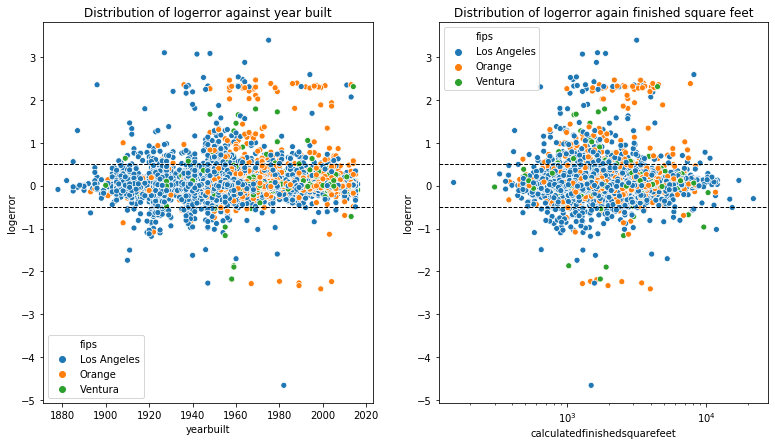

In [18]:
# Plot the distribution of log error against the yearbuilt and calculatedfinishedsquarefeet

plt.figure(figsize=(13,7))

# Against yearbuild
plt.subplot(121)
ax1 = sns.scatterplot(data=train, x='yearbuilt', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror against year built')

# Against calculatedfinishedsquarefeet
plt.subplot(122)
ax2 = sns.scatterplot(data=train, x='calculatedfinishedsquarefeet', y='logerror', hue='fips')
ax2.set(xscale='log')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror again finished square feet')

# Finally, the picture is saved as logerror_year_square.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways: similar pattern shows up.</b><br></div>

Text(0.5, 1.0, 'Distribution of logerror against latitude')

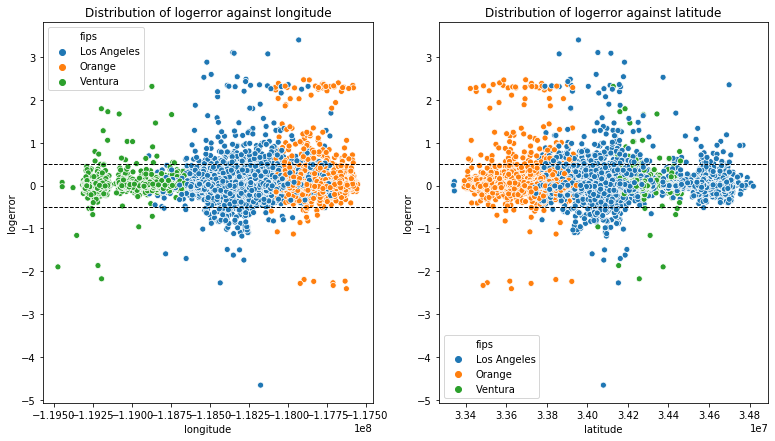

In [19]:
# Plot the distribution of logerror against longitude and latitude
plt.figure(figsize=(13,7))

# Against longitude
plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror against longitude')

# Against latitude
plt.subplot(122)
sns.scatterplot(data=train, x='latitude', y='logerror', hue='fips')
plt.axhline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.5, color='k', linestyle='dashed', linewidth=1)
plt.title('Distribution of logerror against latitude')

# Finally, the picture is saved as logerror_long_lat.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways: As I further explored, a similar pattern keeps repeating itself. All of this let me decide to chase it down: how about clustering the zillow dataset on the logerror?</b></div>

> ## *What if Clustering on logerror?*

> ## *What if Clustering on logerror?*
> - ### *Group 1 features: logtaxvaluedollarcnt, logerror*
> - ### *Group 2 features: taxvaluedollarcnt, logerror*
> - ### *Group 3 features: (taxvaluedollarcnt, logerror), (latitude, longitute)*
> - ### *Group 4 features: (taxvaluedollarcnt, logerror), (year)*

<div class="alert alert-block alert-warning"><b>Attention Please:</b><br>
    1. Only the most helpful clustersing result is shown here: clustering on group 2 features.<br> 
    2. Please find clustering on the rest of the 3 in cluster_zillow.ipynb.</div>

In [20]:
# Acquire the zillow dataset
zillow = acquire.get_zillow_clustering()

# Wrangle the zillow dataset for the purpose of clustering
train, validate, test = wrangle_zillow.wrangle_zillow_clustering_2(zillow)

In [21]:
# Create a new varible for train/validate/test: log-transformed taxvaluedollarcnt

train['logtaxvaluedollarcnt'] = np.log10(train.taxvaluedollarcnt)
validate['logtaxvaluedollarcnt'] = np.log10(validate.taxvaluedollarcnt)
test['logtaxvaluedollarcnt'] = np.log10(test.taxvaluedollarcnt)

### Clustering on features group 2: taxvaluedollarcnt, logerror

In [23]:
# Create columns to cluster on
cols_to_cluster = ['taxvaluedollarcnt', 'logerror']

# Create train/validate/test dataset with interested features only
train_g2 = train[cols_to_cluster]
validate_g2 = validate[cols_to_cluster]
test_g2 = test[cols_to_cluster]

# Scaled the datasets by standard scaler
scaler, train_g2_scaled, validate_g2_scaled, test_g2_scaled = prepare.standard_scaler(train_g2, 
                                                                                      validate_g2, 
                                                                                      test_g2)
# Print the scaler object, shape of the scaled datasets 
scaler, train_g2_scaled.shape, validate_g2_scaled.shape, test_g2_scaled.shape

(StandardScaler(copy=True, with_mean=True, with_std=True),
 (31028, 2),
 (13299, 2),
 (7823, 2))

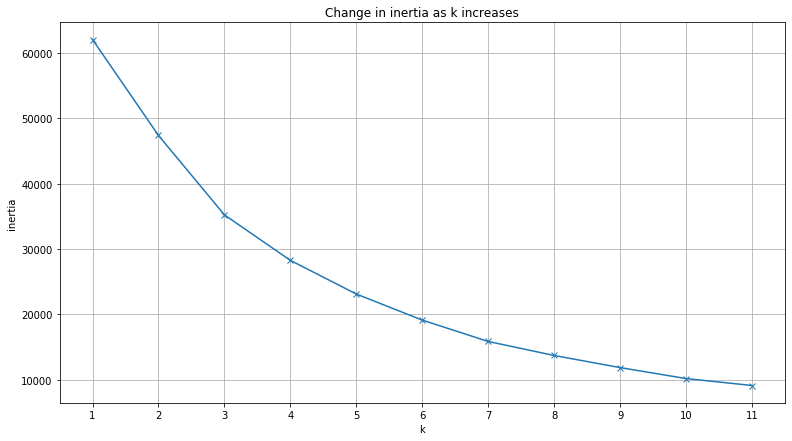

In [30]:
# Choosing optimal clusters by elbow method 

# Create a dictionary to hold the inertias
output = {}

# Iterate k from 1 to 11, calculate their inertias and store them in the dictionary 
for k in range(1, 12): 
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(train_g2_scaled)
    output[k] = kmeans.inertia_

# Visualize the inertia against k
ax = pd.Series(output).plot(figsize=(13,7), marker='x')
ax.set(xlabel='k', ylabel='inertia', xticks=range(1,12), title='Change in inertia as k increases')
ax.grid()

In [26]:
# Based on the above visualization, I chose 6 as the number of clusters. 
# Convert the labels to dataframe named cluster2. 

kmeans2, cluster2 = model.kmeans_labels(train_g2_scaled, cols_to_cluster, 6)
cluster2.head()

,cluster
71142,0
11459,0
54330,0
46830,0
53521,0


In [27]:
# Join the labels with the train dataset

train = pd.concat([train, cluster2], axis=1)
train.rename(columns={'cluster': 'cluster2'}, inplace=True)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,error_type,fips_Orange,fips_Ventura,logtaxvaluedollarcnt,cluster2
71142,17052781,2.0,3.0,6.0,1164.0,1164.0,2.0,34450589.0,-119275390.0,6911.0,...,166435.0,436893.0,270458.0,5302.10,0.045179,1,0,1,5.640375,0
11459,11162056,3.0,4.0,7.0,2682.0,2682.0,3.0,34437293.0,-118382780.0,6048.0,...,307938.0,399176.0,91238.0,6231.12,0.000996,1,0,0,5.601164,0
54330,14033552,3.0,5.0,6.0,2194.0,2194.0,3.0,33723432.0,-117930813.0,6365.0,...,164767.0,379971.0,215204.0,4447.62,-0.012577,0,1,0,5.579750,0
46830,12918779,2.0,3.0,4.0,1586.0,1586.0,2.0,34096557.0,-117918930.0,6544.0,...,52013.0,82223.0,30210.0,1311.36,-0.029993,0,0,0,4.914993,0
53521,13993542,2.0,4.0,6.0,1619.0,1619.0,2.0,33826921.0,-117955128.0,6090.0,...,42755.0,64480.0,21725.0,1066.06,-0.038353,0,1,0,4.809425,0


Text(0.5, 1.0, 'Clustering target variable logerror')

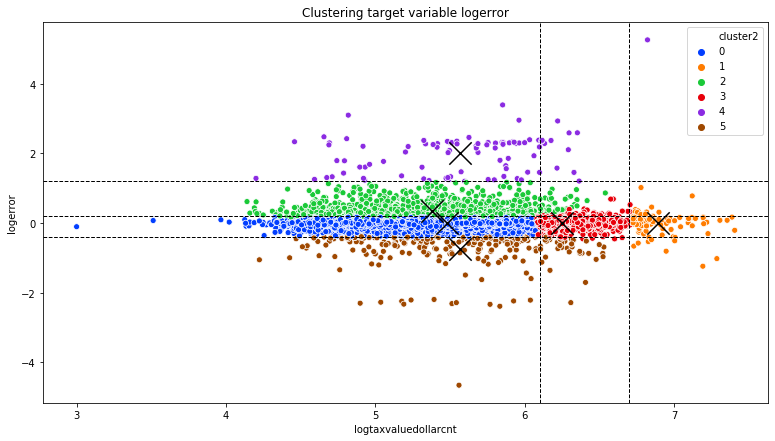

In [26]:
# Visualize the clusters along with their centers

# Set up the fiture size
plt.figure(figsize=(13,7))

# Scatterplot the clusters
ax = sns.scatterplot(data=train, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')

# Plot the dashed line to draw the boundaries of the clusters
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)

# Scatterplot the centers of the clusters
train.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                              marker='x', s=500, ax=ax, c='black')
# Write the title
plt.title('Clustering target variable logerror')

# # Finally, the picture is saved as clustering_logerror.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The observations are grouped into 6 clusters.<br>
    2. Based on logtaxvaluedollarcnt, the observations are grouped into 3:<br>
        - Economic: values below about 1 million: cluster in purple, green, blue and brown<br>
        - Comfortable: between 1 and 5 million: cluster in red<br>
        - Luxury: values above 5 million: cluster in orange<br>
    3. Based on logerror, the observations could be grouped into 4:<br>
        - Low error: clusters in blue, red, and orange<br>
        - Medium positive error: cluster in green<br>
        - High positive error: cluster in purple<br>
        - Medium/high negative error: cluster in brown.</div>

> ## *Where are the medium or high logerror located?*
    > ### - *Do they form clusters on the map?* 

Text(0.5, 1.0, 'luxury')

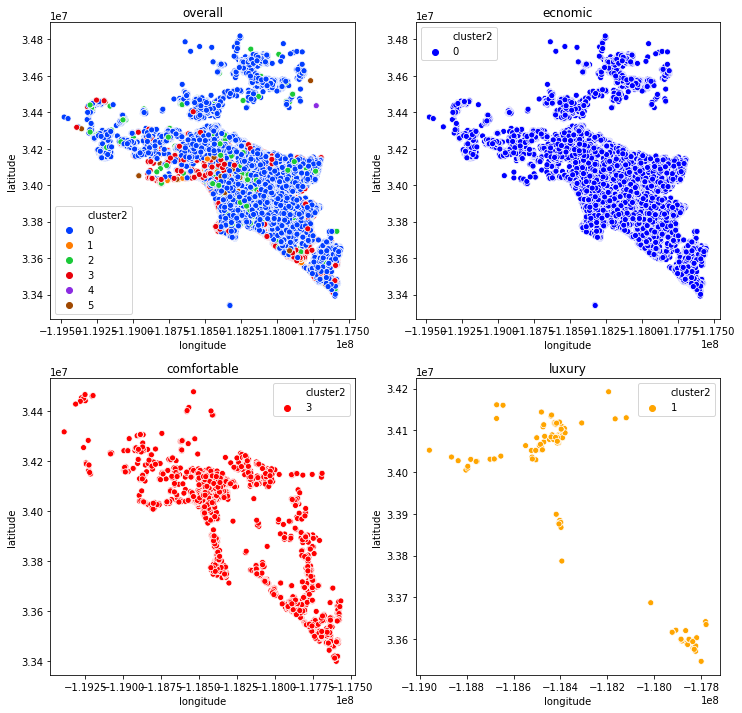

In [28]:
# Visualize the location (longitude and latitude) for all clusters, cluster number 0, 3, and 1. 

plt.figure(figsize=(12,12))

# Scatterplot all the clusters
plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')
plt.title('overall')

# Scatterplot cluster 0
plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 0], 
                           x='longitude', y='latitude', hue='cluster2', palette=['blue'])
plt.title('ecnomic')

# Scatterplot cluster 3
plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 3], 
                           x='longitude', y='latitude', hue='cluster2', palette=['red'])
plt.title('comfortable')

# Scatterplot cluster 1
plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 1], 
                           x='longitude', y='latitude', hue='cluster2', palette=['orange'])
plt.title('luxury')

# Finally, the picture is saved as logerror_long_lat.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. As the property value goes up, they gradually move towards the two ends of the three counties, creating a hollow in the LA county.<br> 
    2. Several luxury properties are clustered in the LA downtown.<br> 
    3. Such pattern is not uncommon.</div>

Text(0.5, 1.0, 'error type: medium/high negative')

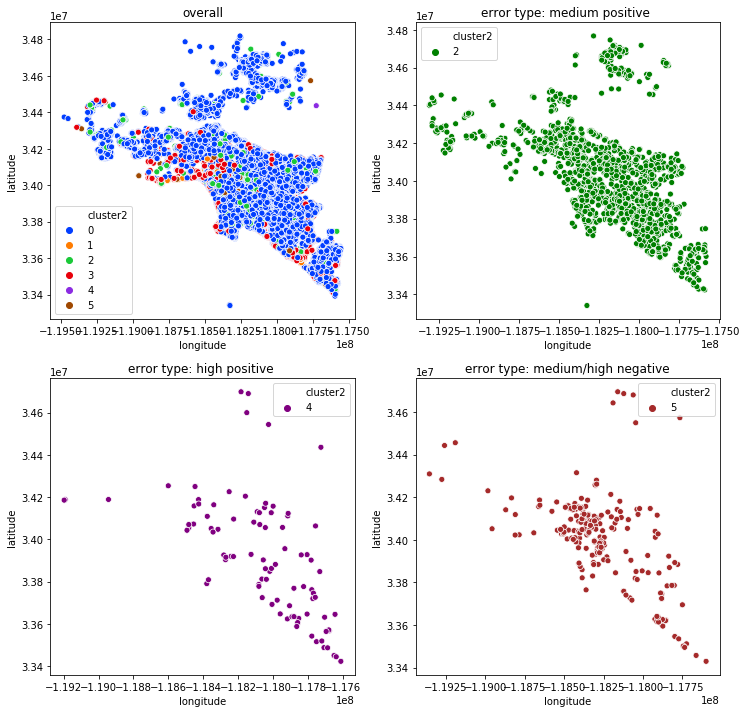

In [31]:
# Visualize the location (longitude and latitude) for all clusters, cluster number 2, 4, and 5. 

plt.figure(figsize=(12,12))

# Scatterplot all the clusters
plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='cluster2', palette='bright')
plt.title('overall')

# Scatterplot cluster number 2
plt.subplot(222)
sns.scatterplot(data=train[train.cluster2 == 2], 
                           x='longitude', y='latitude', hue='cluster2', palette=['green'])
plt.title('error type: medium positive ')

# Scatterplot cluster number 4
plt.subplot(223)
sns.scatterplot(data=train[train.cluster2 == 4], 
                           x='longitude', y='latitude', hue='cluster2', palette=['purple'])
plt.title('error type: high positive ')

# Scatterplot cluster number 5
plt.subplot(224)
sns.scatterplot(data=train[train.cluster2 == 5], 
                           x='longitude', y='latitude', hue='cluster2', palette=['brown'])
plt.title('error type: medium/high negative')

# Finally, the picture is saved as logerror_long_lat.png for the purpose of presentation.

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The positive logerror, whether medium or high, has no specific clusters among three counties. They seems all over the place.<br>
    2. The meidum/high negative logerror has an obvious cluster in LA country.</div>

> ## *Conclusions:*
> ### *- The logerror is tends to increase as the property value drops.*
> ### *- The logerror can be clustered into 6 groups based on the property value and error range.*
> ### *- No specific clusters of medium/high positve logerror are found based on longitude and latitude.*
> ### *- Medium/high nagetive logerror has a obvious cluster in LA country.* 

> ## *Thanks for your attention.* 
> ## *This marks the end of the presentation. Below are modeling and model evalutions.*

<div class="alert alert-block alert-warning"><b>Please Read:<b><br>
    <b>Modeling Introduction<b><br>
        - I planned to model every cluster (total 6) in the optimal result generated by K-means.<br> 
        - Due to the limited time for the project (2 days), I am only able to modeling 1 clusters.<br>
        - The cluster I chose is the most frequenct one: the economic properties with low logerror.<br>
        - A new feature is created: error_type to indicate the sign of the logerror.<br>
        - The train/validate/test datasets are read from .csv produced in cluster_zillow.ipynb.</div>

In [38]:
# Review the relative frequency of the 6 clusters

train.cluster2.value_counts(normalize=True)

0    0.865057
3    0.070743
2    0.050116
5    0.007445
1    0.003642
4    0.002997
Name: cluster2, dtype: float64

### Scale train/validate/test for the economic properties with low logerror by standardscaler
- The reason why to choose the standardscaler is to keep the scaling method consistent within the same project.

In [39]:
# Load train/validate/test datasets from .csv for the purpose of modeling
# All the observations in .csv has been labeled.

train = pd.read_csv('train.csv', index_col=0)
validate = pd.read_csv('validate.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

# Create masks for the economic properties with low logerror

mask_tr = (train.cluster2 == 0)
mask_v = (validate.cluster2 == 0)
mask_t = (test.cluster2 == 0)

# Create train/validate/test for the economic properties with low logerror

train_0 = train[mask_tr]
validate_0 = validate[mask_v]
test_0 = test[mask_t]

# Create a variable to hold the numeric features need to be scaled (16 in total) 

columns_to_scale = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
                    'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
                    'latitude', 'longitude', 'lotsizesquarefeet',
                    'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
                    'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
                    'logtaxvaluedollarcnt']

# Scale train/validate/test for the economic properties with low logerror

scaler_0, train_scaled_0, validate_scaled_0, test_scaled_0 = prepare.scale_standard(train_0,
                                                                                    validate_0,
                                                                                    test_0,
                                                                                    columns_to_scale)
# Print out the scaler object and the shape of three datasets

scaler_0, train_scaled_0.shape, validate_scaled_0.shape, test_scaled_0.shape

(StandardScaler(copy=True, with_mean=True, with_std=True),
 (26841, 24),
 (11496, 22),
 (6798, 22))

### Visualize the clustering using the validate/test datasets

Text(0.5, 1.0, 'Clustering target variable logerror using validate dataset')

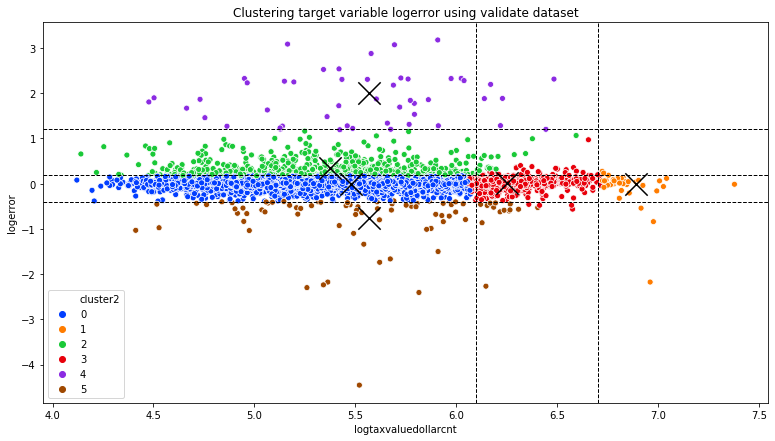

In [46]:
# Set up the fiture size
plt.figure(figsize=(13,7))

# Scatterplot the clusters using validate dataset
ax = sns.scatterplot(data=validate, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')

# Plot the dashed line to draw the boundaries of the clusters
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)

# Scatterplot the centers of the clusters
validate.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt',
                                                 marker='x', s=500, ax=ax, c='black')
# Write the title
plt.title('Clustering target variable logerror using validate dataset')

Text(0.5, 1.0, 'Clustering target variable logerror using test dataset')

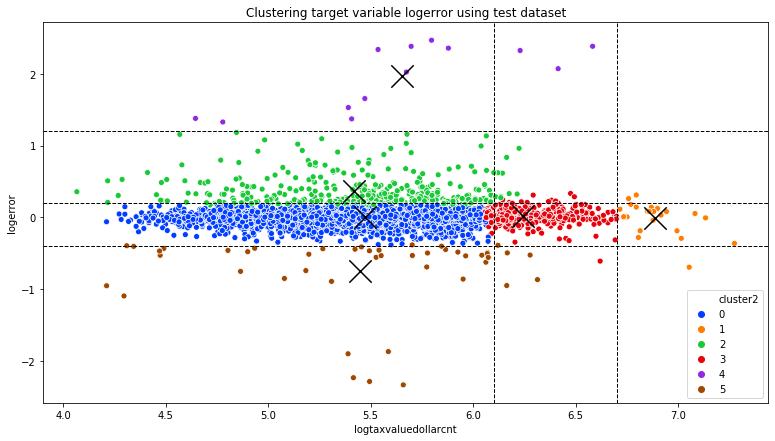

In [47]:
# Set up the fiture size
plt.figure(figsize=(13,7))

# Scatterplot the clusters using test dataset
ax = sns.scatterplot(data=test, x='logtaxvaluedollarcnt', y='logerror', hue='cluster2', palette='bright')

# Plot the dashed line to draw the boundaries of the clusters
plt.axhline(0.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(1.2, color='k', linestyle='dashed', linewidth=1)
plt.axhline(-0.4, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(6.7, color='k', linestyle='dashed', linewidth=1)

# Scatterplot the centers of the clusters
test.groupby('cluster2').mean().plot.scatter(y='logerror', x='logtaxvaluedollarcnt', 
                                             marker='x', s=500, ax=ax, c='black')
# Write the title
plt.title('Clustering target variable logerror using test dataset')

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The validate and test dataset are clustered into 6 groups, similar to the training dataset.<br>
    2. No overfitting is observed through visualization</div>

### Feature Engineering on training dataset
- Top 10 features are selected out of 19 in total

In [48]:
# Show all the columns in training dataset, 19 in total

predictors=['error_type', 'fips_Orange', 'fips_Ventura',
            'bathroomcnt_scaled', 'bedroomcnt_scaled', 'buildingqualitytypeid_scaled',
            'calculatedfinishedsquarefeet_scaled', 'finishedsquarefeet12_scaled',
            'fullbathcnt_scaled', 'latitude_scaled', 'longitude_scaled',
            'lotsizesquarefeet_scaled', 'roomcnt_scaled', 'yearbuilt_scaled',
            'structuretaxvaluedollarcnt_scaled', 'taxvaluedollarcnt_scaled',
            'landtaxvaluedollarcnt_scaled', 'taxamount_scaled','logtaxvaluedollarcnt_scaled']

In [49]:
# Create X and y for train/validate/test

X_train_scaled = train_scaled_0[predictors]
y_train = train_scaled_0['logerror']

X_validate_scaled = validate_scaled_0[predictors]
y_validate = validate_scaled_0['logerror']

X_test_scaled = test_scaled_0[predictors]
y_test = test_scaled_0['logerror']

# Print out shape of the X_train/validate/test_scaled

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((26841, 19), (11496, 19), (6798, 19))

### Select top 10 features by select KBset

In [50]:
# Call function to select top 10 features by select KBest

f_features = features.select_kbest(X_train_scaled, y_train, 10)

# Print out top 10 features
f_features

['error_type',
 'fips_Orange',
 'bathroomcnt_scaled',
 'bedroomcnt_scaled',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'fullbathcnt_scaled',
 'roomcnt_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled']

### Select top 10 features by RFE

In [51]:
# Call function to select top 10 features by rfe

rfe_features = features.rfe(X_train_scaled, y_train, 10)

# Print out rfe_features

rfe_features

['error_type',
 'fips_Ventura',
 'calculatedfinishedsquarefeet_scaled',
 'finishedsquarefeet12_scaled',
 'latitude_scaled',
 'yearbuilt_scaled',
 'structuretaxvaluedollarcnt_scaled',
 'taxvaluedollarcnt_scaled',
 'landtaxvaluedollarcnt_scaled',
 'logtaxvaluedollarcnt_scaled']

<div class="alert alert-block alert-info"><b>Takeaways:</b><br>
    1. The validate and test dataset are clustered into 6 groups, similar to the training dataset.<br>
    2. No overfitting is observed through visualization</div>

### Set up baseline

In [40]:
# Compute baseline prediction using mean

mean, median = y_train_1_1.agg(['mean', 'median'])

baseline = np.array([mean]*y_train_1_1.size)

baseline[:5], len(baseline)

(array([0.00195396, 0.00195396, 0.00195396, 0.00195396, 0.00195396]), 15165)

In [41]:
# Compute baseline sse

baseline_residual = y_train_1_1 - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

72.8356969472252

In [42]:
# Compute baseline mse

baseline_mse = baseline_sse/y_train_1_1.size
baseline_mse

0.0048028814340405675

In [43]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_1_1, baseline)**1/2
baseline_rmse

0.0024014407170202838

### Test 3 different algorithms for f_features and rfe_features
- LinearRegression
- LassoLars
- Poly(2nd degree)

In [44]:
# Create X_train_scaled for f_features and rfe_features

X_train_scaled_1_1_f = X_train_scaled_1_1[f_features_1_1]
X_train_scaled_1_1_rfe = X_train_scaled_1_1[rfe_features_1_1]

### LinearRegression

In [45]:
# Create lm object

lm = LinearRegression(normalize=True)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [46]:
# Fit train dataset with f_features, predict and calculate the lm_rmse

lm_f = lm.fit(X_train_scaled_1_1_f, y_train_1_1)
lm_pred_f = lm_f.predict(X_train_scaled_1_1_f)
lm_rmse_f = mean_squared_error(y_train_1_1, lm_pred_f)**1/2

lm_rmse_f

0.0013638278316285659

In [47]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lm_rfe = lm.fit(X_train_scaled_1_1_rfe, y_train_1_1)
lm_pred_rfe = lm_rfe.predict(X_train_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_train_1_1, lm_pred_rfe)**1/2

lm_rmse_rfe

0.001362398014085791

### LassoLars()

In [48]:
# Create lars object (alpha=0.1)

lars = LassoLars(alpha=0.1)
lars

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [49]:
# Fit train dataset with f_features, predict and calculate the rmse

lars_f = lars.fit(X_train_scaled_1_1_f, y_train_1_1)
lars_pred_f = lars_f.predict(X_train_scaled_1_1_f)
lars_rmse_f = mean_squared_error(y_train_1_1, lars_pred_f)**1/2

lars_rmse_f

0.0024014407170202838

In [50]:
# Fit train dataset with rfe_features, predict and calculate the lm_rmse

lars_rfe = lars.fit(X_train_scaled_1_1_rfe, y_train_1_1)
lars_pred_rfe = lars_rfe.predict(X_train_scaled_1_1_rfe)
lars_rmse_rfe = mean_squared_error(y_train_1_1, lars_pred_rfe)**1/2

lars_rmse_rfe

0.0024014407170202838

### Poly(2nd Degree)

In [51]:
# Transform X_train_scaled_f and _rfe to squared.

pf2 = PolynomialFeatures(degree=2)
X_train_scaled_squared_f = pf2.fit_transform(X_train_scaled_1_1_f)
X_train_scaled_squared_rfe = pf2.fit_transform(X_train_scaled_1_1_rfe)

In [52]:
# Create lm_squared object

lm_squared2 = LinearRegression()

In [53]:
# Fit X_train_scaled_squared_f, predict and compute the rmse

lm_squared_f = lm_squared2.fit(X_train_scaled_squared_f, y_train_1_1)
lm_squared_pred_f = lm_squared_f.predict(X_train_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_train_1_1, lm_squared_pred_f)**1/2
lm_squared_rmse_f

0.001286513535963518

In [54]:
# Fit X_train_scaled_squared_rfe, predict and compute the rmse

lm_squared_rfe = lm_squared2.fit(X_train_scaled_squared_rfe, y_train_1_1)
lm_squared_pred_rfe = lm_squared_rfe.predict(X_train_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_train_1_1, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

0.0013232589698699358

In [55]:
# Summarize the RMSE of all 6 models

rmse_values = [baseline_rmse,
               lm_rmse_f, lm_rmse_rfe, 
               lars_rmse_f, lars_rmse_rfe, 
               lm_squared_rmse_f, lm_squared_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_rmse_f', 'lm_rmse_rfe',
              'lars_rmse_f', 'lars_rmse_rfe',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe']

rmse_train = pd.DataFrame(rmse_values, index=rmse_index, columns=['train_RMSE'])
rmse_train.sort_values(by='train_RMSE')

,train_RMSE
lm_squared_rmse_f,0.001287
lm_squared_rmse_rfe,0.001323
lm_rmse_rfe,0.001362
lm_rmse_f,0.001364
baseline_rmse,0.002401
lars_rmse_f,0.002401
lars_rmse_rfe,0.002401


### Validate top 3 models
### Poly(2nd) with both f_ and rfe_features

In [56]:
# Create X_validate_scaled for f_features and rfe_features

X_validate_scaled_1_1_f = X_validate_scaled_1_1[f_features_1_1]
X_validate_scaled_1_1_rfe = X_validate_scaled_1_1[rfe_features_1_1]

In [57]:
# Transform X_validate_scaled_f and _rfe to squared.

X_validate_scaled_squared_f = pf2.transform(X_validate_scaled_1_1_f)
X_validate_scaled_squared_rfe = pf2.transform(X_validate_scaled_1_1_rfe)

In [58]:
# Predict and compute the rmse

lm_squared_pred_f = lm_squared_f.predict(X_validate_scaled_squared_f)

lm_squared_rmse_f = mean_squared_error(y_validate_1_1, lm_squared_pred_f)**1/2
lm_squared_rmse_f

5.553328183871766e+20

In [59]:
# Predict and compute the rmse

lm_squared_pred_rfe = lm_squared_rfe.predict(X_validate_scaled_squared_rfe)

lm_squared_rmse_rfe = mean_squared_error(y_validate_1_1, lm_squared_pred_rfe)**1/2
lm_squared_rmse_rfe

2.359372893449051e+17

### LinearRegression with rfe features

In [60]:
# Predict and compute the rmse

lm_pred = lm.predict(X_validate_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_validate_1_1, lm_pred)**1/2

lm_rmse_rfe

0.0013295100424344794

In [61]:
rmse_values = [baseline_rmse,
               lm_squared_rmse_f, lm_squared_rmse_rfe,
               lm_rmse_rfe]
rmse_index = ['baseline_rmse',
              'lm_squared_rmse_f', 'lm_squared_rmse_rfe',
              'lm_rmse_rfe']

rmse_validate = pd.DataFrame(rmse_values, index=rmse_index, columns=['validate_RMSE'])
rmse_validate.sort_values(by='validate_RMSE')

,validate_RMSE
lm_rmse_rfe,1.329510e-03
baseline_rmse,2.401441e-03
lm_squared_rmse_rfe,2.359373e+17
lm_squared_rmse_f,5.553328e+20


### Test for the best model: LinearRegression with rfe features

In [62]:
# Create X_train_scaled for rfe_features

X_test_scaled_1_1_rfe = X_test_scaled_1_1[rfe_features_1_1]
X_test_scaled_1_1_f = X_test_scaled_1_1[f_features_1_1]

In [63]:
# Predict and compute the rmse

lm_pred = lm.predict(X_test_scaled_1_1_rfe)
lm_rmse_rfe = mean_squared_error(y_test_1_1, lm_pred)**1/2

lm_rmse_rfe

0.0013398546021102945

In [64]:
rmse_values = [baseline_rmse,lm_rmse_rfe]
rmse_index = ['baseline_rmse','lm_rmse_rfe']

rmse_test = pd.DataFrame(rmse_values, index=rmse_index, columns=['test_RMSE'])
rmse_test.sort_values(by='test_RMSE')

,test_RMSE
lm_rmse_rfe,0.001340
baseline_rmse,0.002401


In [65]:
rmse_overall = pd.concat([rmse_train, rmse_validate], axis=1)
rmse_overall = pd.concat([rmse_overall, rmse_test], axis=1)

rmse_overall.sort_values(by='train_RMSE')

,train_RMSE,validate_RMSE,test_RMSE
lm_squared_rmse_f,0.001287,5.553328e+20,NaN
lm_squared_rmse_rfe,0.001323,2.359373e+17,NaN
lm_rmse_rfe,0.001362,1.329510e-03,0.001340
lm_rmse_f,0.001364,NaN,NaN
baseline_rmse,0.002401,2.401441e-03,0.002401
lars_rmse_f,0.002401,NaN,NaN
lars_rmse_rfe,0.002401,NaN,NaN


## Takeaways from Modeling

## Discussion the reasons behind the best and worst model

Text(0.5, 1.0, 'Distribution of predicted y by the best model')

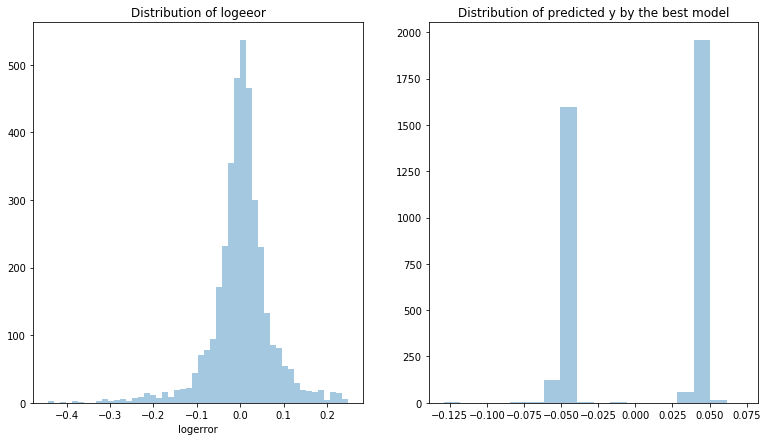

In [66]:
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.distplot(y_test_1_1, kde=False)
plt.title('Distribution of logeeor')

plt.subplot(122)
sns.distplot(pd.Series(lm_pred), kde=False)
plt.title('Distribution of predicted y by the best model')

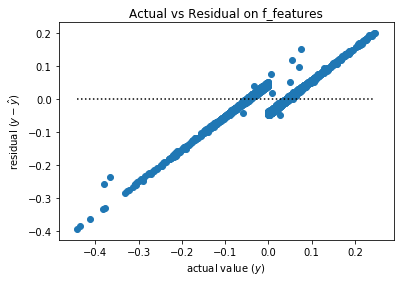

In [67]:
model.plot_residuals(y_test_1_1, pd.Series(lm_pred).values, 'f_features')

Text(0.5, 1.0, 'Distribution of predicted y by the worst model')

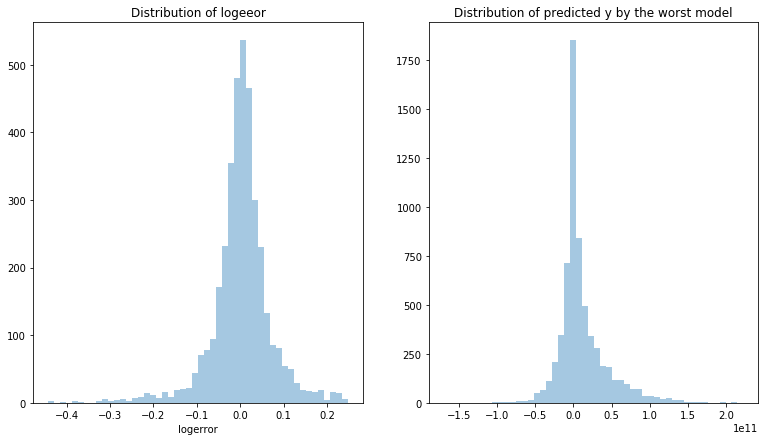

In [68]:
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.distplot(y_test_1_1, kde=False)
plt.title('Distribution of logeeor')

plt.subplot(122)
sns.distplot(pd.Series(lm_squared_pred_f), kde=False)
plt.title('Distribution of predicted y by the worst model')

Text(0.5, 1.0, 'Distribution of predicted y by the worst model')

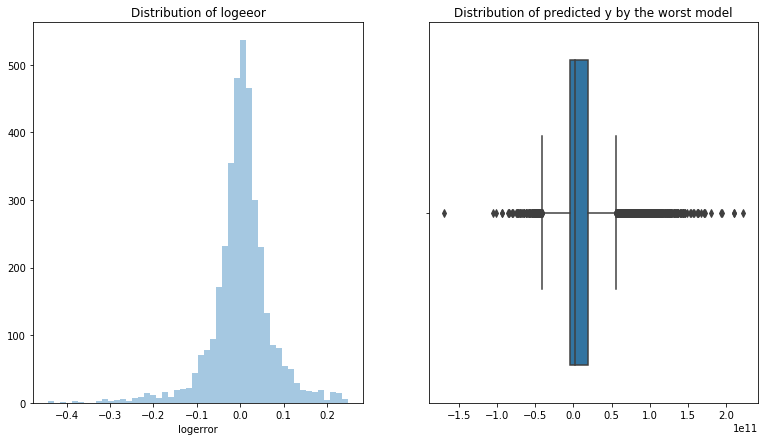

In [69]:
plt.figure(figsize=(13,7))
plt.subplot(121)
sns.distplot(y_test_1_1, kde=False)
plt.title('Distribution of logeeor')

plt.subplot(122)
sns.boxplot(pd.Series(lm_squared_pred_f))
plt.title('Distribution of predicted y by the worst model')